In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

XGBoost version: 2.0.3


In [339]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

N=4000, N_train=3000, L=4


[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 1
[ 24.771  46.131 -49.161 -39.356] 1
[-20.13   15.641  30.981  37.218] 1
[46.465 22.369 14.248 21.745] 1


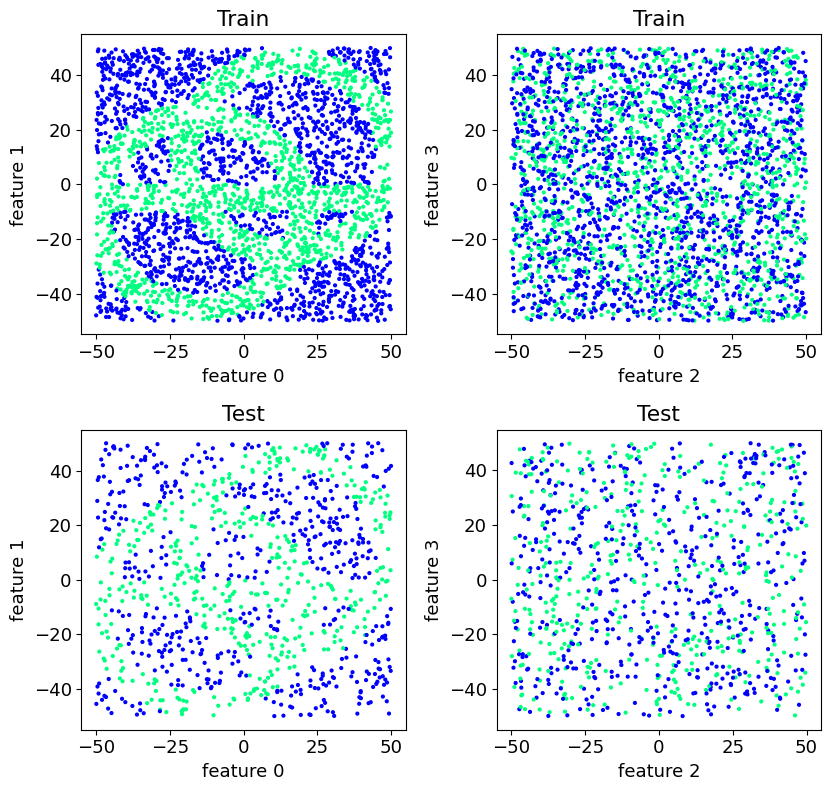

In [186]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

In [341]:
def classify(clf=GradientBoostingClassifier(),show=False, show_prediction_plot=True):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_test, y_test)),clf.score(x_test, y_test)))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    if show_prediction_plot:
        fig,AX = plt.subplots(1,2,figsize=(8.2,4))
        scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
        scat(AX[1],x_train[:],y_train,title="training set")
        fig.tight_layout()
        plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show()
    return clf.score(x_test, y_test)

### Classify
If the “objective” hyperparameter is left unspecified, XGBClassifier looks at the data and chooses automatically the loss functions and the evaluation metrics (--> WARNING)

## XGBoost
https://xgboost.readthedocs.io/en/stable/python/python_api.html

errors: 5.20%   Accuracy=0.948


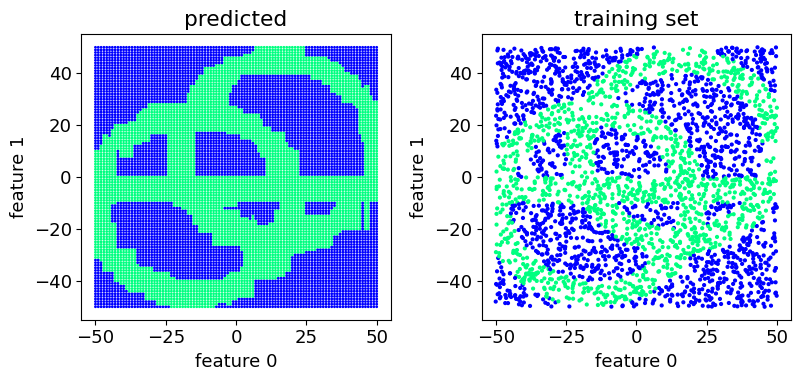

num_trees= 100


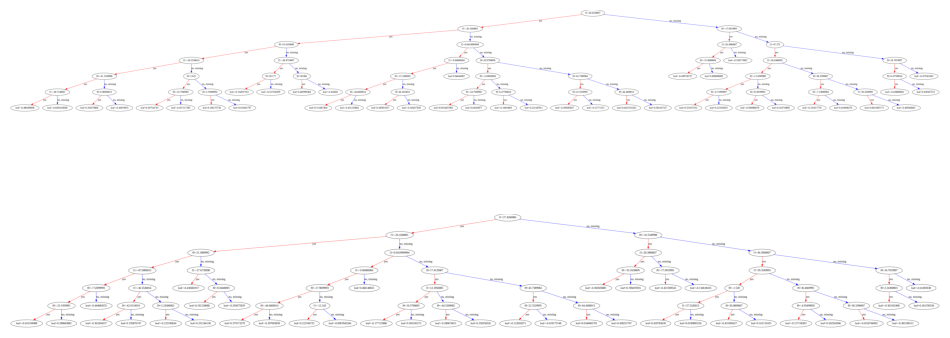

In [188]:
xgb_model = XGBClassifier(seed=1,
                      objective='binary:logistic') 
       # importance_type="gain" #weight, cover, ...
       # learning_rate=0.4,
       # reg_lambda=0.001, 
       # n_estimators=30)

classify(xgb_model, show=True)

None
[0.4891835  0.37623835 0.06590363 0.06867457]


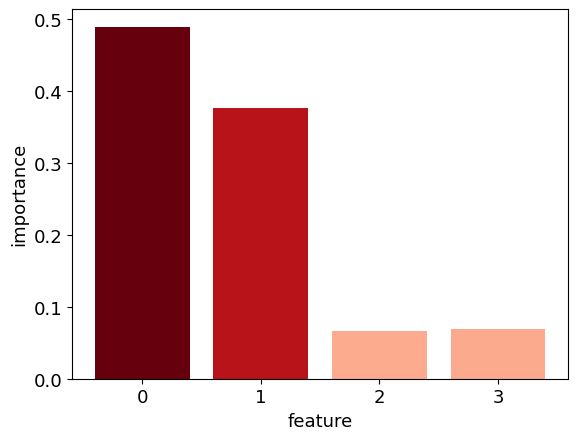

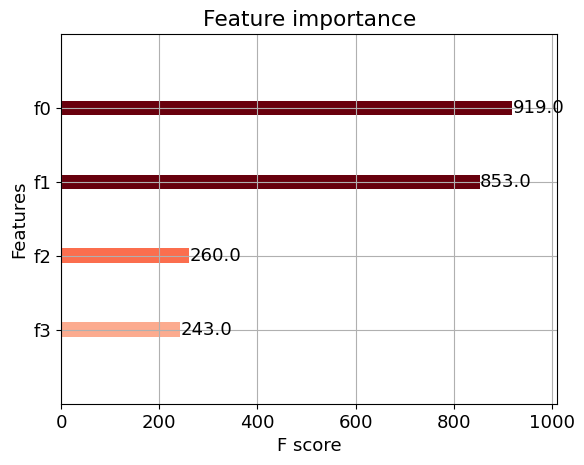

In [189]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance

def plot_feature_importance_analysis(model):
        print(model.importance_type)
        print(model.feature_importances_)
        # plot
        my_cmap = plt.get_cmap("Reds")
        rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
        plt.bar(range(len(model.feature_importances_)), model.feature_importances_,
                color=my_cmap(rescale(model.feature_importances_)))
        plt.xlabel("feature")
        plt.ylabel("importance")
        plt.xticks(np.arange(L))
        plt.title(model.importance_type)
        plt.show()

        rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
        plot_importance(model,color=my_cmap(rescale_r(model.feature_importances_)))
        plt.show()

plot_feature_importance_analysis(xgb_model)

Documentation: https://xgboost.readthedocs.io/en/stable/python/python_api.html

    ‘weight’: the number of times a feature is used to split the data across all trees.

    ‘gain’: the average gain across all splits the feature is used in.

    ‘cover’: the average coverage across all splits the feature is used in.

    ‘total_gain’: the total gain across all splits the feature is used in.

    ‘total_cover’: the total coverage across all splits the feature is used in.


0 weight [919. 853. 260. 243.]
1 gain [4.56883669 3.5139606  0.61552137 0.64140123]
2 total_gain [4198.76074219 2997.40844727  160.03555298  155.86050415]
3 cover [49.8643837  66.05692291 54.26316071 54.39147949]
4 total_cover [45825.3671875  56346.5546875  14108.421875   13217.12988281]


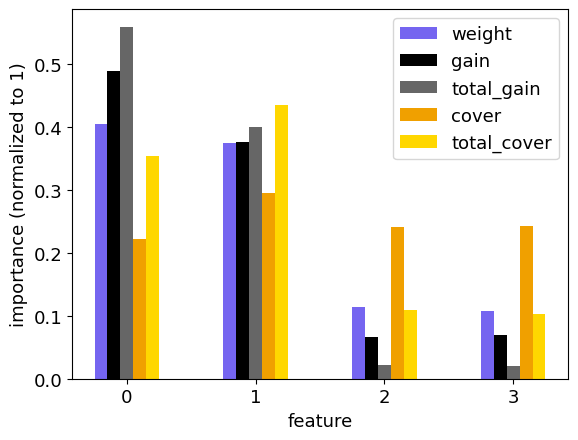

In [190]:
def plot_importance_type_analysis(model):

    # if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
    list_type=["weight","gain","total_gain","cover","total_cover"]
    list_col=["#7565F0","k","#666666","#F0A000","gold"]

    for i,t in enumerate(list_type):
        feature_imp = model.get_booster().get_score(importance_type=t)
        keys = list(feature_imp.keys())
        values = np.array(list(feature_imp.values()))
        print(i,t,values)
        values= values/np.sum(values)
        plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
    plt.xlabel("feature")
    plt.ylabel("importance (normalized to 1)")
    plt.xticks(np.arange(L))
    plt.legend()
    plt.show()

plot_importance_type_analysis(xgb_model)

## normal Gradient Boosting

errors: 19.50%   Accuracy=0.805


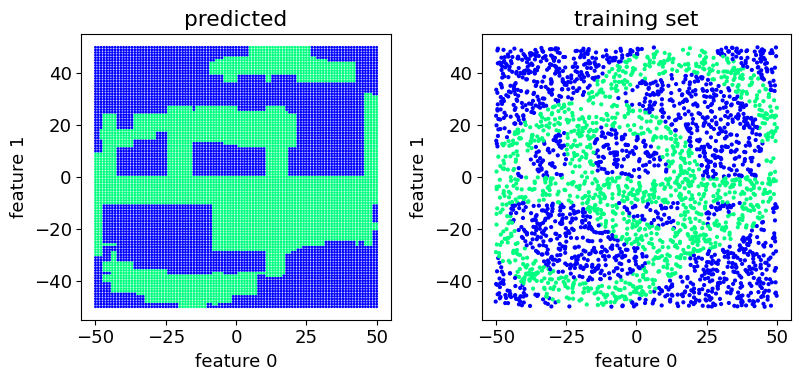

In [166]:
# GradientBoostingClassifier()
classify()

## AdaBoost

/usr/local/lib64/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


errors: 34.10%   Accuracy=0.659


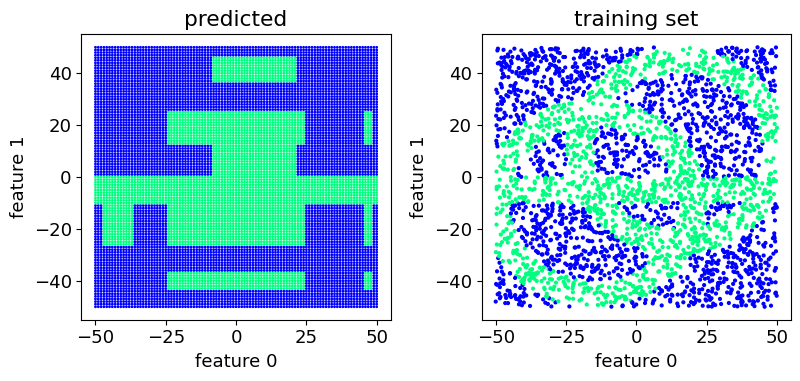

In [167]:
classify(clf=AdaBoostClassifier())

# 1. Model complexity, parameters and regularization

First we explore the parameters space logarithmically, to span many orders of magnitude efficiently. We use GridSearchCV from sklearn library.
(The code below is very slow to run. Commented as a precaution)

In [ ]:
'''
parameters0 = {'importance_type' : ['gain', 'weight', 'cover', 'total_gain', 'total_cover'],
       'learning_rate' : list(map(lambda x: 10**x, range(-5, 1, 1))),
       'reg_lambda' : list(map(lambda x: 10**x, range(-5, 1, 1))), 
       'n_estimators' : range(50,300, 50)
             }
clf = GridSearchCV(model, parameters0, cv=4)
GSCV=clf.fit(x, y)
'''


"\nparameters0 = {'importance_type' : ['gain', 'weight', 'cover', 'total_gain', 'total_cover'],\n       'learning_rate' : list(map(lambda x: 10**x, range(-5, 1, 1))),\n       'reg_lambda' : list(map(lambda x: 10**x, range(-5, 1, 1))), \n       'n_estimators' : range(50,300, 50)\n             }\nclf = GridSearchCV(model, parameters0, cv=4)\nGSCV=clf.fit(x, y)\n"

Then we focus on the most promising ranges exploring them linearly.

In [ ]:
parameters1 = {'importance_type' : ['gain', 'weight', 'cover', 'total_gain', 'total_cover'],
      'learning_rate' : list(np.linspace(0, 1, 10)),
      'reg_lambda' : list(np.linspace(0, 1, 10)),
      'n_estimators' : range(50,300, 50),
      'max_depth' : range(2, 11, 2)
             }
clf = GridSearchCV(model, parameters1, cv=4)
GSCV=clf.fit(x, y)

In order to look for the simplest yet effective and accurate model, we select the subset of the parameters combinations, evaluated above, that produced an accuracy higher than a threshold we deem sufficiently good. Then, we look for the combinations that minimize the complexity, defined in a proper way. 

Indeed, we define a `complexity_estimate` function that takes as arguments the max depth of the trees, the number of estimators and the *l2*-norm of the model parameters. 

We follow the form of the $\Omega$-regularization defined in Mehta (sum over estimators of number of leaves plus *l2*-norm): 
* summing over trees corresponds to multiply by n_estimators in first approximation (we assume tree 'complexity' to be homogeneous);
* we assumed the number of leavs to be roughly ~$2^{max_depth}$, but after some trials we find out that approximating the dependency as linear (with a weight `u`) leads to a more stable complexity estimation w.r.t. the `max_depth` parameter;
* finally we assume that the bigger the `reg_lambda` parameter is, the smaller the *l2*-norm will be kept by the learning algorithm. Thus we add to the complexity a term inversely proportional to `reg_lambda`, weighted by a `v` parameter.

We tune `u` and `v` manually.

The goal is to quantify *a priori* (i.e., before training) the complexity of the model as well as possible.

In order to incentivize small increase in complexity as far as they would bring to big accuracxy improvement, we also multiply the complexity function described above by a $1-accuracy$ factor.

In [382]:
import pandas as pd
from itertools import product as CartProd
print('best parameters combination of global grid search, with score associated:\n ', GSCV.best_params_,GSCV.best_score_ )
#print(clf.param_grid)
param_combs=list(CartProd(*clf.param_grid.values()))
df=pd.DataFrame(param_combs, columns=['importance_type', 'learning_rate', 'reg_lambda', 'n_estimators', 'max_depth'])
#print(df)
df['mean_accuracy']=GSCV.cv_results_['mean_test_score']
good_accuracy=0.9
df_good=df[df['mean_accuracy']>good_accuracy]
def complexity_estimate(n_estimators, reg_lambda, max_depth, accuracy): 
    u,v=0.021,1
    return n_estimators*(u*max_depth+v/reg_lambda)*(1-accuracy)
df_good['complexity']=complexity_estimate(df_good['n_estimators'], df_good['reg_lambda'], df_good['max_depth'], df_good['mean_accuracy'])
# Finding the row with the minimum value in column 'A'
min_row_index = df_good['complexity'].idxmin()
# Retrieving the row corresponding to the minimum value in column 'A'
min_row = df_good.loc[min_row_index]
print('LESS COMPLEX YET SUFFICIENTLY GOOD MODEL:\n', min_row)

best parameters combination of global grid search, with score associated:
  {'importance_type': 'gain', 'learning_rate': 0.1111111111111111, 'max_depth': 10, 'n_estimators': 200, 'reg_lambda': 0.0} 0.94825
LESS COMPLEX YET SUFFICIENTLY GOOD MODEL:
 importance_type        gain
learning_rate      0.222222
reg_lambda              1.0
n_estimators             50
max_depth                 4
mean_accuracy         0.945
complexity            2.981
Name: 726, dtype: object


/tmp/ipykernel_58109/1973740472.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_good['complexity']=complexity_estimate(df_good['n_estimators'], df_good['reg_lambda'], df_good['max_depth'], df_good['mean_accuracy'])


The resulting model scores a sufficiently high accuracy on the cross-validation, and the number of estimators and the depth are reasonably low. The l2 regularization term is 1, contributing to keep the model simple.

/usr/local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:36:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "complexity", "mean_accuracy" } are not used.

  warnings.warn(smsg, UserWarning)


errors: 9.80%   Accuracy=0.902


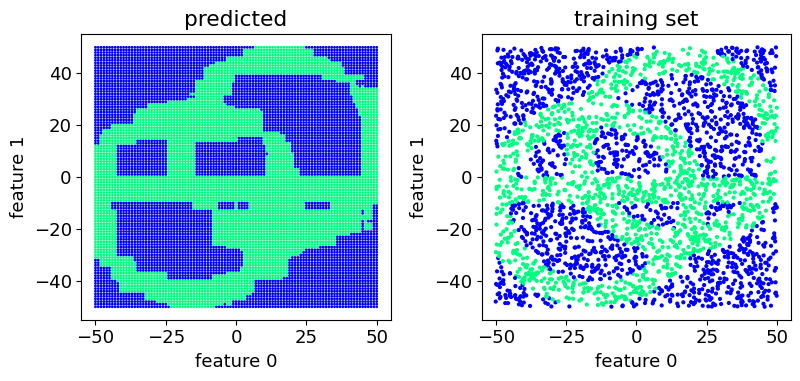

num_trees= 50


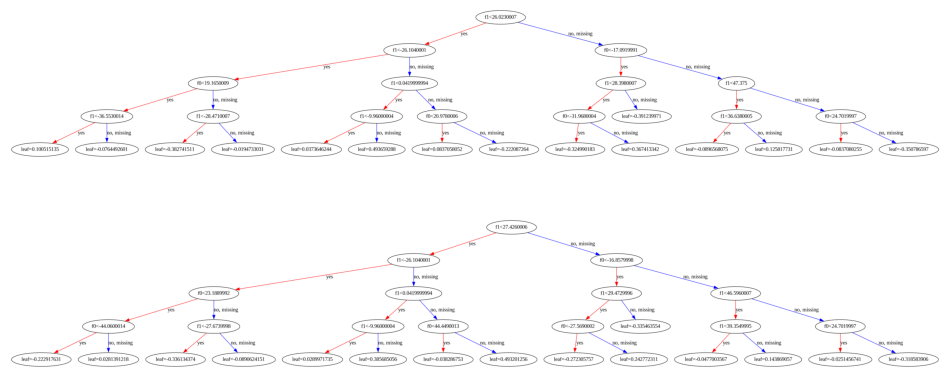

In [274]:
simple_good_params=dict(min_row)
simple_good_params['seed']=1
simple_good_params['objective']='binary:logistic'
simple_good_model=XGBClassifier(**dict(min_row))
classify(simple_good_model, show=True)

The plots of the results are satisfying.

gain
[0.26684728 0.5794144  0.0689235  0.08481488]


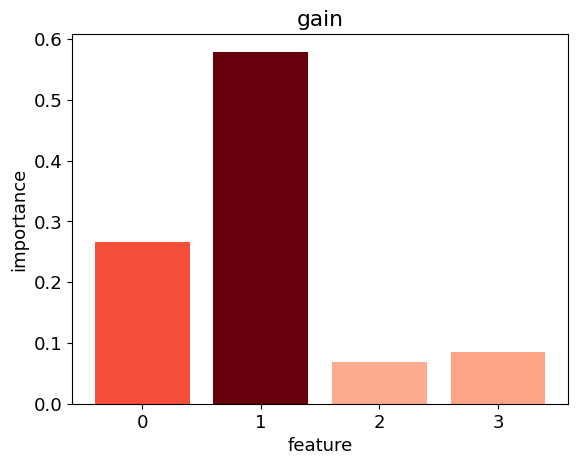

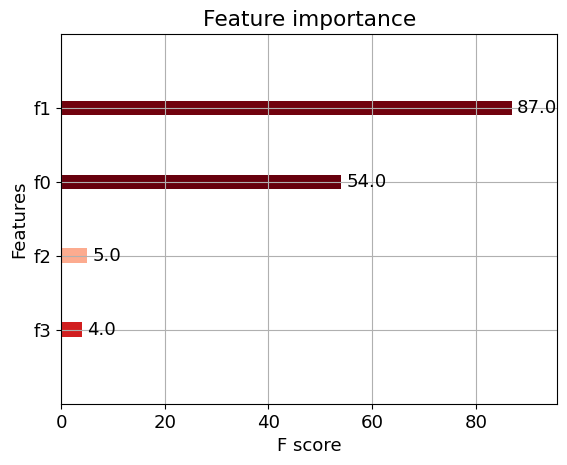

In [191]:
plot_feature_importance_analysis(simple_good_model)

0 weight [54. 87.  5.  4.]
1 gain [18.81690216 40.85776901  4.86018372  5.9807744 ]
2 total_gain [1016.1126709  3554.62597656   24.30091858   23.92309761]
3 cover [410.87713623 467.68978882 361.61026001 531.26959229]
4 total_cover [22187.36523438 40689.01171875  1808.05126953  2125.07836914]


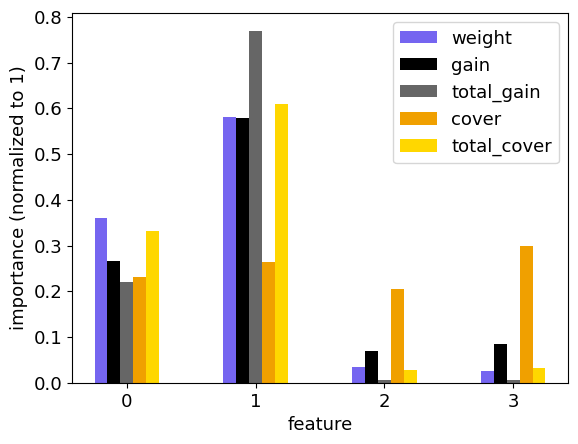

In [192]:
plot_importance_type_analysis(simple_good_model)

Let's compare execution time of the simpified and the defaukt version of the XGBoost models:

In [ ]:
print('........................................xgb_model timing.....................................')
%timeit classify(xgb_model, show_prediction_plot=False)
print('................................simple_good_model timing.....................................')
%timeit classify(simple_good_model, show_prediction_plot=False)

The results are respectively 62.9 secs and 39.9 secs.

In [346]:
print(39.9/62.9*100)

63.43402225755167


The `simple_good_model` proves faster, as expected, taking 63.4% the time `xgb_model` takes.

# 2. Dimensionality reduction

From the previous feature importance plots we can see that the 0 and 1 features are the relevant ones. We see that the standard PCA is uncapable of distinguish them instead, since the variance of the 2 and 3 coordinates is as much as high, despite them being essentially noise.

In [193]:
from scipy import linalg as la
cov= np.cov(x.T)
l, V= la.eig(cov)
l=np.real_if_close(l)
print(f'components weight (%) from PCA: {l/np.trace(cov)*100}')


components weight (%) from PCA: [26.07473378 24.88232424 24.67585953 24.36708245]


We reduce the data according to the importance analysis, to see how the accuracy of the model changes.

In [194]:
x=x[:, 0:2]

N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]

errors: 16.30%   Accuracy=0.837


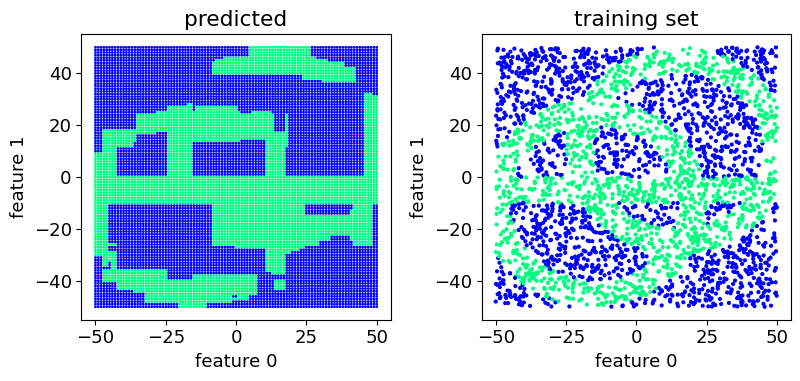

In [195]:
classify()

We observe that the accuracy of the normal Gradient Boosting model improves with dimensionality (feature) reduction.

errors: 4.50%   Accuracy=0.955


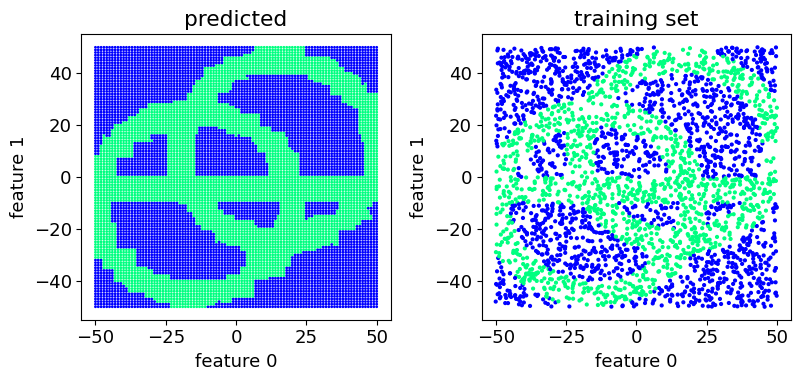

In [196]:
classify(xgb_model)

We observe instead that the accuracy of the XGBoost model slightly improves.

/usr/local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:42:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "complexity", "mean_accuracy" } are not used.

  warnings.warn(smsg, UserWarning)


errors: 9.80%   Accuracy=0.902


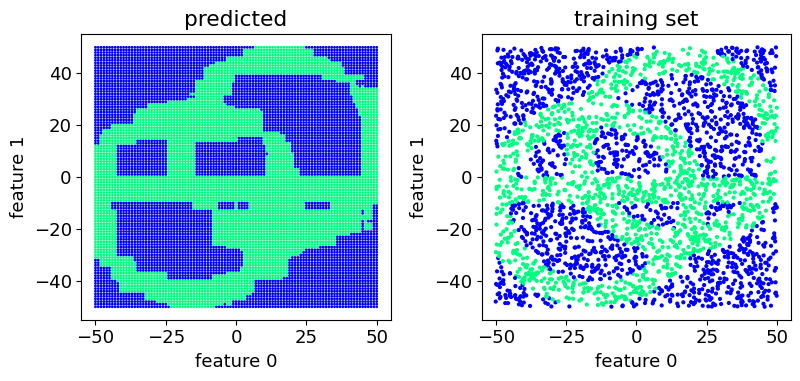

In [275]:
classify(simple_good_model)

Instead, with our `simple_good_model` the accuracy stays the same.

### experimental attempt (work in progress) ↓

Below an attempt of dimensionality increase with potentially useful functions of the dataset, according to visual interpretation.

N=4000, N_train=3000, L=5
[ -31.608     -29.544     602.407936  516.7136   3856.6736  ] 0
[  46.451      15.318     412.821124 5056.736525  806.116525] 1
[  24.771      46.131    2614.379161 5155.131602 1714.521602] 1
[ -20.13       15.641     426.050881  657.477781 1723.647781] 1
[  46.465      22.369     749.062161 5465.348386 1002.078386] 1


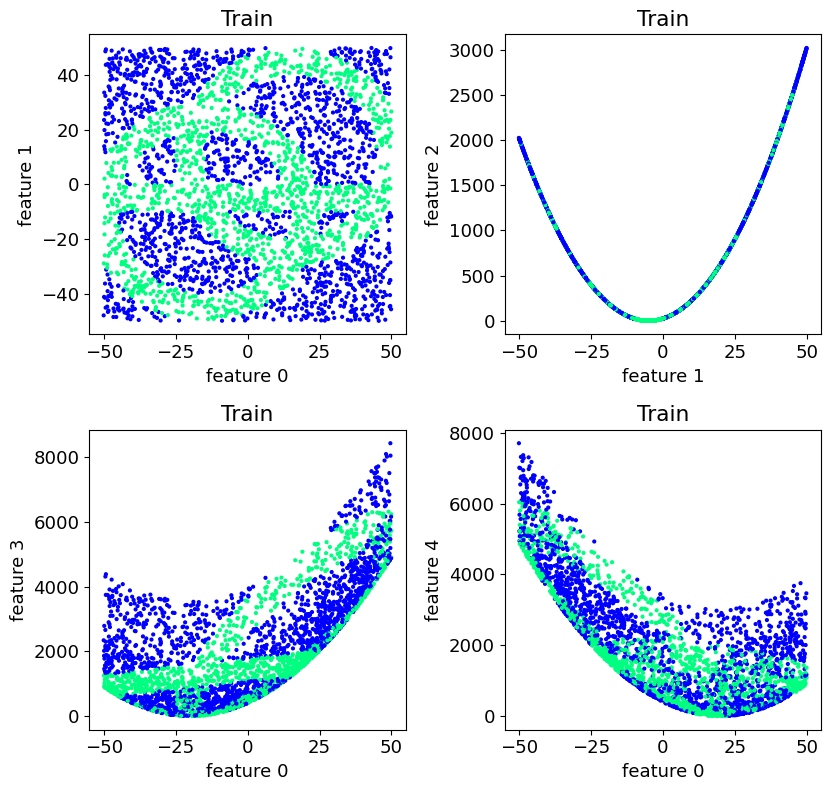

In [402]:
x=np.vstack((x[:,0], x[:,1], (x[:,1]+5)**2, (x[:,0]+20)**2+(x[:,1]+10)**2, (x[:,0]-20)**2+(x[:,1]-5)**2))
x=x.T
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")
for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=1,j=2,title="Train")
scat(AX[1,0],x_train,y_train,i=0,j=3,title="Train")
scat(AX[1,1],x_train,y_train,i=0,j=4,title="Train")
fig.tight_layout()
plt.show()

errors: 2.00%   Accuracy=0.980


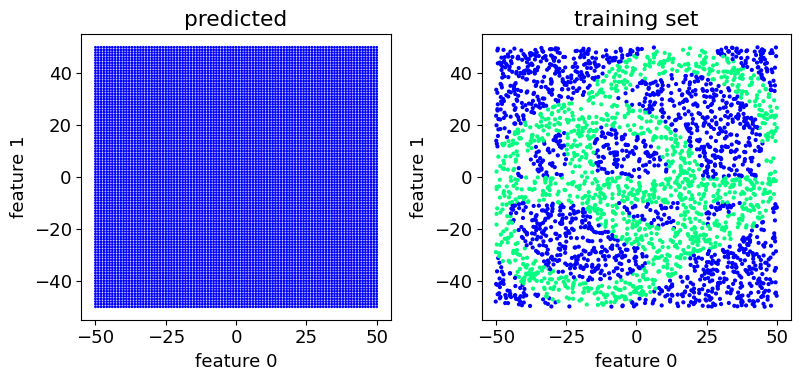

0.98

In [403]:
classify(xgb_model)

Despite the perplexing plot resulting, we are going to further explore this attempt in the next days for the assignment. 

# 3. XGBoost vs NN

In [362]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

N=4000, N_train=3000, L=4


In [352]:
import tensorflow as tf
#We implement a subclass just to make it work in the 3rd Section with the sklearn.cross_validate method
class Sequential_with_score(tf.keras.Sequential):
    def score(self, *args, **kwargs):
        return self.evaluate(**args, **kwargs)
# Define the dimensions
input_dim = x_train.shape[1]  # Assuming x_train is your training input data

# Define the architecture of the neural network
nn_model = Sequential_with_score([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classifier with sigmoid activation
])

# Compile the model
nn_model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy loss
              metrics=['accuracy'])

# Train the model on the entire training dataset
nn_model.fit(x_train, y_train, epochs=10, batch_size=32)

# Evaluate the model on test data
test_loss, test_accuracy = nn_model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
def classify_nn(nn_model):
    # Train the model on the entire training dataset
    nn_model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Evaluate the model on test data
    test_loss, test_accuracy = nn_model.evaluate(x_test, y_test)
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-test_accuracy),test_accuracy))
    return test_accuracy


Epoch 1/10
94/94 [==============================] - 1s 663us/step - loss: 0.8535 - accuracy: 0.5540
Epoch 2/10
94/94 [==============================] - 0s 693us/step - loss: 0.6578 - accuracy: 0.6030
Epoch 3/10
94/94 [==============================] - 0s 652us/step - loss: 0.6402 - accuracy: 0.6183
Epoch 4/10
94/94 [==============================] - 0s 666us/step - loss: 0.6278 - accuracy: 0.6217
Epoch 5/10
94/94 [==============================] - 0s 682us/step - loss: 0.6177 - accuracy: 0.6367
Epoch 6/10
94/94 [==============================] - 0s 649us/step - loss: 0.6163 - accuracy: 0.6443
Epoch 7/10
94/94 [==============================] - 0s 625us/step - loss: 0.6134 - accuracy: 0.6473
Epoch 8/10
94/94 [==============================] - 0s 675us/step - loss: 0.5929 - accuracy: 0.6667
Epoch 9/10
94/94 [==============================] - 0s 652us/step - loss: 0.5990 - accuracy: 0.6563
Epoch 10/10
32/32 [==============================] - 0s 575us/step - loss: 0.6197 - accuracy: 0.6480

In [371]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Define the architecture of the neural network
nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=10)

# Train the model on the entire training dataset
nn_model.fit(x_train, y_train)

# Evaluate the model on test data
y_pred = nn_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)
def classify_nn(nn_model):
    # Train the model on the entire training dataset
    nn_model.fit(x_train, y_train)

    # Evaluate the model on test data
    test_accuracy = accuracy_score(y_test, nn_model.predict(x_test))
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-test_accuracy),test_accuracy))
    return test_accuracy


Test Accuracy: 0.5447222222222222


/usr/local/lib64/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


## a) Train set - Test set

In [ ]:
xgb_accs=[]
nn_accs=[]
fs=np.linspace(0.1, 0.9, 10)
for f in fs:
    print(f'...................................Train set ratio: {f*100:.1f}%............................................')
    N,L = len(x), len(x[0])

    N_train = int(f*N)
    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test = x[N_train:],y[N_train:]
    print('xgb_model')
    xgb_accs.append(classify(xgb_model, show_prediction_plot=False))
    print('nn_model')
    nn_accs.append(classify_nn(nn_model))

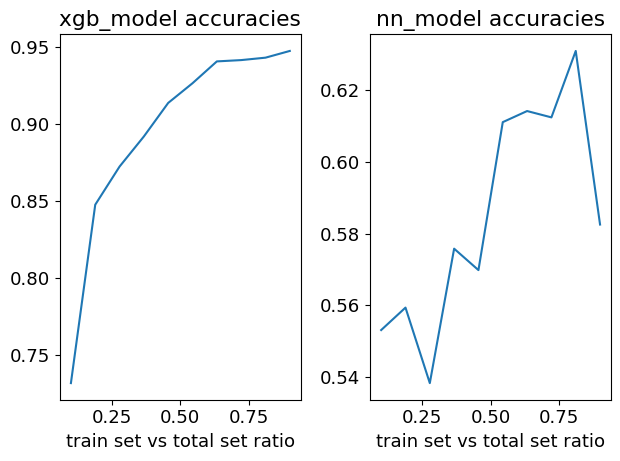

In [364]:
fig, (ax1, ax2)=plt.subplots(nrows=1, ncols=2)
ax1.plot(fs,xgb_accs)
ax1.set_title('xgb_model accuracies')
ax1.set_xlabel('train set vs total set ratio')
ax2.plot(fs, nn_accs)
ax2.set_title('nn_model accuracies')
ax2.set_xlabel('train set vs total set ratio')
fig.tight_layout()
plt.show()

We observe that the accuracy of the XGBoost model improves steadily, while the accuracy of the neural network oscillates heavily.

In [ ]:
xgb_accs=[]
nn_accs=[]
fs=np.linspace(0.001, 0.1, 100)
for f in fs:
    print(f'...................................Train set ratio: {f*100:.1f}%............................................')
    N,L = len(x), len(x[0])

    N_train = int(f*N)
    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test = x[N_train:],y[N_train:]
    print('xgb_model')
    xgb_accs.append(classify(xgb_model, show_prediction_plot=False))
    print('nn_model')
    nn_accs.append(classify_nn(nn_model))

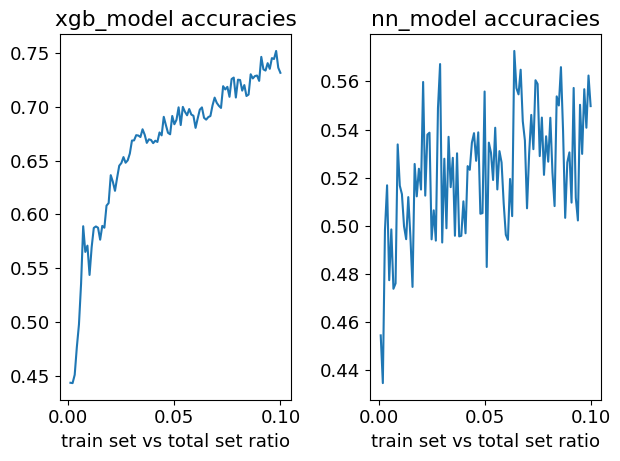

In [379]:
fig, (ax1, ax2)=plt.subplots(nrows=1, ncols=2)
ax1.plot(fs,xgb_accs)
ax1.set_title('xgb_model accuracies')
ax1.set_xlabel('train set vs total set ratio')
ax2.plot(fs, nn_accs)
ax2.set_title('nn_model accuracies')
ax2.set_xlabel('train set vs total set ratio')
fig.tight_layout()
plt.show()

Exploring the lower range of *N'* we observe that the progression of the accuracy for the XGBoost is much more stable than out simple NN model. We observe that the accuracy is higher for the `xgb_model` even for small size training set.

## Cross-validation

We now do the same vaying the number fo folds of the k-fold validation process.

In [ ]:
from sklearn.model_selection import cross_validate

xgb_accs=[]
nn_accs=[]
ks=range(2, 11, 1)
for k in ks:
    print(f'...................................Train set ratio (CV): {(k-1)/k*100:.1f}%............................................')
    print('xgb_model')
    scores=cross_validate(xgb_model, x,y,cv=k)
    print(scores['test_score'].mean())
    xgb_accs.append(scores['test_score'].mean())
    print('nn_model')
    scores=cross_validate(nn_model, x,y,cv=k)
    print(scores['test_score'].mean())
    nn_accs.append(scores['test_score'].mean())

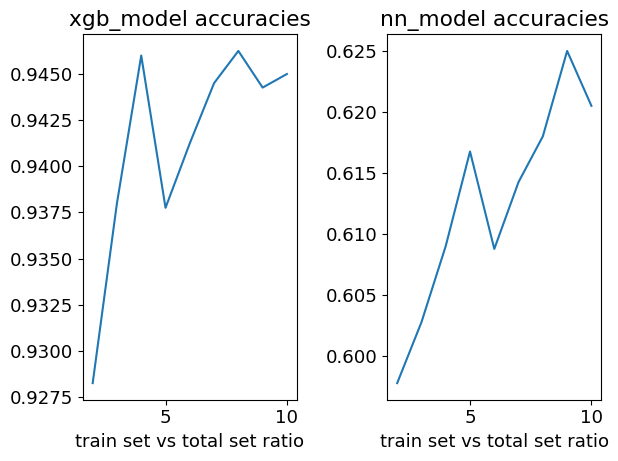

In [360]:
fig, (ax1, ax2)=plt.subplots(nrows=1, ncols=2)
ax1.plot(ks,xgb_accs)
ax1.set_title('xgb_model accuracies')
ax1.set_xlabel('train set vs total set ratio')
ax2.plot(ks, nn_accs)
ax2.set_title('nn_model accuracies')
ax2.set_xlabel('train set vs total set ratio')
fig.tight_layout()
plt.show()

The `xgb_model` shows as well in this case a steadily higher accuracy value w.r.t. the simple NN model.